In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
from collections import OrderedDict
import pickle
import pickle5
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import auc, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.utils import resample
from pysurvival.models.semi_parametric import CoxPHModel
from lifelines.utils import concordance_index
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score,classification_report, f1_score
from sklearn.metrics import plot_confusion_matrix

## block warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open("../data/ut_poiV6.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df.head()

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,...,near_inactivity_6H,near_charge_events_6H,service,entertainment,food,childcare,medical,education,parking,waste-management
0,928.5,2018-01-31 19:51:00,2018-02-01 11:19:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
1,363.5,2018-02-01 14:03:00,2018-02-01 20:06:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
2,6828.5,2018-02-01 21:15:00,2018-02-06 15:03:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
3,5871.5,2018-02-06 15:27:00,2018-02-10 17:18:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,1,Tuesday,15,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
4,1454.5,2018-02-10 18:26:00,2018-02-11 18:40:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,5,Saturday,18,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959


### Remove events

In [3]:
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    rows = temp[temp['lag3'].isna()]
    if rows.life_time.sum() < 3*60:
        print("The station has the lagged")
        print(name)

# remove rows
df = df.dropna()

The station has the lagged
BOULDER / REC CENTER
The station has the lagged
BOULDER / ATRIUM ST1
The station has the lagged
BOULDER / ALPINE ST1
The station has the lagged
COMM VITALITY / 1400 WALNUT1
The station has the lagged
BOULDER / FACILITIES ST1
The station has the lagged
COMM VITALITY / 1500PEARL
The station has the lagged
BOULDER / JUNCTION ST1
The station has the lagged
COMM VITALITY / BOULDER JCTN
The station has the lagged
COMM VITALITY / 1100WALNUT1
The station has the lagged
BOULDER / BOULDER PARK
The station has the lagged
COMM VITALITY / 2200 BROADWAY1
The station has the lagged
BOULDER / EAST REC
The station has the lagged
BOULDERJUNCTION / JUNCTION ST1


In [4]:
df.shape

(12699, 71)

In [5]:
## Limit to only top 10 stations
temp = df.groupby(['Station_Name']).count().latitude # group the data for each station
names = temp.sort_values(ascending=False)
names = names.index.values

### Remove outliers

In [7]:
# remove outliers
drop_index = [] # list of indexes to keep
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    # Get interquantile ranges
    Q1, Q3 = temp.life_time.quantile([0.25, 0.75])
    IQR = Q3-Q1
    minimum = Q1 - 1.5*IQR
    maximum = Q3 + 1.5*IQR
    # Define observations which should be removed
    temp2 = df[(df['life_time'] < minimum) | (df['life_time'] > maximum) &
                  (df['Station_Name'] == name)]
    print("{n}: {s} ({p} %)".format(n=name, 
                                    s=temp2.shape[0], 
                                    p=round((temp2.shape[0]/temp.shape[0])*100,2)))
    # Add the indexes which should be dropped
    drop_index.extend(list(temp2.index))
    
print("\nThe total amount of lost events: {n} ({p} %)".format(n=len(drop_index), 
                                                              p=round(len(drop_index)/df.shape[0]*100,2)))

df = df.drop(drop_index)
df = df.reset_index(drop=True)

COMM VITALITY / 1104 SPRUCE1: 57 (4.4 %)
COMM VITALITY / 1000WALNUT: 48 (3.32 %)
BOULDER / REC CENTER: 40 (3.51 %)
BOULDER / BASELINE ST1: 42 (3.53 %)
BOULDER / ATRIUM ST1: 65 (6.58 %)
BOULDER / ALPINE ST1: 32 (8.96 %)
COMM VITALITY / 1400 WALNUT1: 38 (7.29 %)
BOULDER / FACILITIES ST1: 84 (16.28 %)
COMM VITALITY / 1500PEARL: 41 (4.5 %)
BOULDER / JUNCTION ST1: 35 (9.97 %)
COMM VITALITY / BOULDER JCTN: 40 (5.28 %)
COMM VITALITY / 1100WALNUT1: 39 (3.51 %)
BOULDER / N BOULDER REC 1: 29 (2.07 %)
BOULDER / BOULDER PARK: 8 (4.55 %)
COMM VITALITY / 2200 BROADWAY1: 0 (0.0 %)
BOULDER / EAST REC: 23 (5.42 %)
BOULDERJUNCTION / JUNCTION ST1: 3 (3.0 %)

The total amount of lost events: 624 (4.91 %)


In [8]:
df.shape

(12075, 71)

### Usefull functions

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [10]:
## To test model
def test_model(y_test, y_pred):
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    NRMSE = RMSE/np.mean(y_test)
    return MAE, RMSE, MSE, MAPE, NRMSE

In [11]:
## Get point predictions
def point_pred(model, X_test, X_train):
    T_pred = []
    T_pred_train = []
    # Get survival curves
    cph_pred = model.predict_survival(X_test)
    cph_pred_train = model.predict_survival(X_train)
    # get times of survival prediction
    time = model.times
    # test
    for i in range(0,len(cph_pred)):
        T_pred.append(auc(time,cph_pred[i]))
    # train
    for i in range(0,len(cph_pred_train)):
        T_pred_train.append(auc(time,cph_pred_train[i]))
    
    return T_pred, T_pred_train

In [12]:
## Get point predictions
def point_pred_single(model, X_test):
    T_pred = []
    # Get survival curves
    cph_pred = model.predict_survival(X_test)
    # get times of survival prediction
    time = model.times
    # test
    for i in range(0,len(cph_pred)):
        T_pred.append(auc(time,cph_pred[i]))
    
    return T_pred

In [13]:
# function to evaluate only accuracy, precision, recall and f1 score
def evaluate_scores(y_true, y_pred):
    # calculate confusion matrix
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    print("accuracy:", round(accuracy,2))
    print("precision:", round(precision,2))
    print("recall:", round(recall,2))
    print("f1 score:", round(f1,2))
    return accuracy, precision, recall, f1

### Prepare data

In [14]:
def hour_label(X):
    if (X >= 7) & (X <= 10):
        return 'Morning'
    elif (X >= 11) & (X <= 14):
        return 'Midday'
    elif (X >= 15) & (X <= 18):
        return 'Afternoon'
    elif (X >= 19) or (X < 1):
        return 'Evening'
    elif (X >= 1) & (X <= 6):
        return 'Night'

In [15]:
## Add time of day and day of week
df['tod'] = df['hour_b'].apply(hour_label)

In [16]:
df = df[df['tod'] != 'Night']

In [17]:
station_subset = ['BOULDER / N BOULDER REC 1', 'COMM VITALITY / 1000WALNUT', 
        'COMM VITALITY / 1104 SPRUCE1', 'BOULDER / BASELINE ST1']
df4 = df[df['Station_Name'].isin(station_subset)]

In [18]:
print("Shape df 4 station:", df4.shape)

Shape df 4 station: (5110, 72)


Add dummy variables

In [22]:
# Categorical features
columns_categorical = ['weekday_b_name','tod','Station_Name']
df4 = pd.get_dummies(df4, columns=columns_categorical)

Sort dataframes

In [23]:
df4 = df4.sort_values(by=['datetime_start'])

Features

M4 and is used as the name for the Full features constellation throughout the notebook.

In [24]:
features4_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
                 'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
                 'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
                 'tod_Evening','tod_Midday', 'tod_Morning',
                 'Station_Name_BOULDER / N BOULDER REC 1',
                 'Station_Name_COMM VITALITY / 1000WALNUT',
                 'Station_Name_COMM VITALITY / 1104 SPRUCE1']

features4_con = ['lag1', 'lag2', 'lag3','near_charge_time_4H', 'near_charge_energy_4H',
                 'charge_time_4H', 'charge_energy_4H','service', 'entertainment', 'food', 
                 'childcare', 'medical', 'education','parking', 'waste-management']  # dow + agg. tod + lag + activ.

### Check poi features for each station:

In [25]:
split = 0.8

train4, test4 = np.split(df4, [int(split * len(df4))])

In [26]:
for name in names[0:10]:
    temp = df[df['Station_Name'] == name]
    print(name, np.mean(temp['life_time']))
#     print(temp[temporal_features].iloc[0])

COMM VITALITY / 1104 SPRUCE1 548.0998383185125
COMM VITALITY / 1000WALNUT 475.53235082674337
BOULDER / REC CENTER 697.0075329566855
BOULDER / BASELINE ST1 668.2641843971631
BOULDER / ATRIUM ST1 684.9809248554914
BOULDER / ALPINE ST1 1768.3383838383838
COMM VITALITY / 1400 WALNUT1 1278.52079002079
BOULDER / FACILITIES ST1 807.0337209302326
COMM VITALITY / 1500PEARL 833.5865051903114
BOULDER / JUNCTION ST1 1517.3200692041523


In [27]:
split = 0.8

## Get X and y - M5
X = train4[features4_cat+features4_con]
y = train4['life_time']

## split data
X_train4, X_test4 = np.split(X, [int(split * len(X))])
y_train4, y_test4 = np.split(y, [int(split * len(X))])

## Standardize
scaler = StandardScaler()
X_train4[features4_con] = scaler.fit_transform(X_train4[features4_con])
X_test4[features4_con] = scaler.transform(X_test4[features4_con])

# Single-Step - Specific events

The last experiment is simply to make predictions for some specific events. In total I choose 4 events. One during monday midday and one during saturday evening for 1000 WALNUT station. 

- Event 1) Monday midday events in test set for N BOULDER. Choose index 11002. 
- Event 2) Saturday evening events in test set for 1000 WALNUT. Choose index 2193.

In [28]:
idx1 = X_test4[(X_test4['Station_Name_BOULDER / N BOULDER REC 1'] == 1) & (X_test4['weekday_b_name_Monday'] == 1) & (X_test4['tod_Midday'] == 1)].index

In [29]:
y_test4[idx1]

10850    123.5
10870     32.5
10882     55.5
10883     11.5
10911    179.5
10933     25.5
10957    106.5
10971     26.5
11002    183.5
11030    194.5
11053    447.5
Name: life_time, dtype: float64

In [30]:
idx2 = X_test4[(X_test4['Station_Name_COMM VITALITY / 1000WALNUT'] == 1) & (X_test4['weekday_b_name_Saturday'] == 1) & (X_test4['tod_Evening'] == 1)].index

In [31]:
y_test4[idx2]

2193     947.5
2207     915.5
2240    1061.5
2259     113.5
2271     886.5
2288     846.5
2308     877.5
2324    1098.5
2342       0.5
2343     978.5
2362    1102.5
2377     816.5
Name: life_time, dtype: float64

In [33]:
index_specific =  [11002, 2193]
X_specific = X_test4.loc[index_specific]
y_specific = y_test4.loc[index_specific]

## Standardize
X_specific[features4_con] = scaler.transform(X_specific[features4_con])

In [38]:
df.loc[index_specific]['datetime_start']

11002   2019-08-19 12:35:00
2193    2019-06-08 19:47:00
Name: datetime_start, dtype: datetime64[ns]

In [39]:
y_specific

11002    183.5
2193     947.5
Name: life_time, dtype: float64

## Traditional regression methods

Specify hyper parameters

In [40]:
params = {}
params['M1'] = {}
params['M4'] = {}
params['M4']['LR'] = {'alpha':15}
params['M4']['RF'] = {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_depth': 7}
params['M4']['MLP'] = {'hidden_layer_sizes': 256, 'alpha': 0.001, 'activation': 'relu'}
params['M4']['GB'] = {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 3, 'learning_rate': 0.01}

**Linear regression**

In [41]:
param = params['M4']['LR']
reg_LR = Ridge(random_state=42, alpha=param['alpha'])
reg_LR.fit(X_train4,y_train4)

Ridge(alpha=15, random_state=42)

In [42]:
pred = reg_LR.predict(X_specific)
pred

array([-57.72000644, 693.55793485])

**Random forest**

In [43]:
param = params['M4']['RF']
reg_RF = RandomForestRegressor(random_state=42, 
                            min_samples_split=param['min_samples_split'],
                            min_samples_leaf=param['min_samples_leaf'],
                            max_depth=param['max_depth'],
                            n_estimators=param['n_estimators'])    
reg_RF.fit(X_train4, y_train4) 

RandomForestRegressor(max_depth=7, min_samples_leaf=10, min_samples_split=3,
                      n_estimators=500, random_state=42)

In [44]:
pred = reg_RF.predict(X_specific)
pred            

array([444.59911084, 695.95203687])

**Gradient boosting**

In [45]:
param = params['M4']['GB']
reg_GB = GradientBoostingRegressor(random_state=42, 
                                max_depth=param['max_depth'],
                                min_samples_split=param['min_samples_split'],
                                min_samples_leaf=param['min_samples_leaf'],
                                n_estimators=param['n_estimators'], 
                                learning_rate=param['learning_rate'])
reg_GB.fit(X_train4, y_train4)

GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=5,
                          min_samples_split=5, n_estimators=500,
                          random_state=42)

In [46]:
pred = reg_GB.predict(X_specific)
pred

array([330.73098969, 695.14024633])

**MLP**

In [47]:
param = params['M4']['MLP']
reg_MLP = MLPRegressor(random_state=42, alpha=param['alpha'], 
                   hidden_layer_sizes=param['hidden_layer_sizes'],
                   activation = param['activation'],
                   max_iter=500, early_stopping=True)
reg_MLP.fit(X_train4, y_train4)

MLPRegressor(alpha=0.001, early_stopping=True, hidden_layer_sizes=256,
             max_iter=500, random_state=42)

In [48]:
pred = reg_MLP.predict(X_specific)
pred

array([ 409.89682868, 1141.53155363])

## Quantile regression

In [49]:
quantile_labels = ['5th','25th','50th','75th','95th']
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
qr_M4 = pd.DataFrame(columns=quantile_labels)
qr_M4['true'] = y_specific.values

In [50]:
for i in range(len(quantiles)):
    regCPH = GradientBoostingRegressor(random_state=42, max_depth=3,
                                        n_estimators=500, 
                                        learning_rate=0.01,
                                        min_samples_split=5,
                                        min_samples_leaf=5,
                                        loss='quantile', alpha=quantiles[i])
    regCPH.fit(X_train4,y_train4)
    qr_M4[quantile_labels[i]] = regCPH.predict(X_specific)

In [51]:
qr_M4

,5th,25th,50th,75th,95th,true
0,13.667754,54.251126,190.660101,432.897375,1294.003691,183.5
1,32.341910,473.668320,738.600083,827.736667,1121.837532,947.5


### Survival analysis

Split the data for survival analysis

In [52]:
X_train = df4[features4_cat+features4_con]
T_train = df4['life_time']
E_train = np.ones(len(df4))

reg = CoxPHModel()
reg.fit(X_train, T_train, E_train, lr= 0.01, l2_reg=0.1, init_method='zeros', max_iter=800, verbose=False)

CoxPHModel

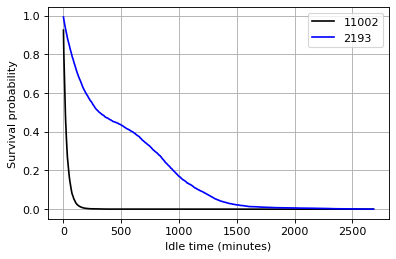

In [53]:
surv = reg.predict_survival(x=X_specific)
time = reg.times

figure(figsize=(5.5, 3.5), dpi=80)

colors = ['k','b']
for i in range(0,len(surv)):
    mean = []
    upper = []
    lower = []
    
    surv_temp = surv[i]

    N = 2

    for k in range(len(time)):
        vals = surv_temp[k]
        mean.append(np.mean(vals))
    plt.plot(time,mean, color=colors[i], label=index_specific[i])
plt.legend()
plt.xlabel("Idle time (minutes)")
plt.ylabel("Survival probability")
plt.grid()
plt.show()

Point estimates predictions

In [54]:
point_predictions = point_pred_single(reg,X_specific)
point_predictions

[27.194941624501837, 504.14947469533774]

# Two-Step - predict for different station

Classify single station

In [55]:
def hsplit(X):
    if X >= 4*60:
        return 1
    else:
        return 0

In [56]:
y_train4C = y_train4.apply(hsplit)

In [57]:
### Train classifier
# Evaluate model
clf = GradientBoostingClassifier(random_state=42, 
                                max_depth=3,
                                min_samples_split=5,
                                min_samples_leaf=3,
                                n_estimators=500, 
                                learning_rate=0.01)
clf.fit(X_train4,y_train4C)

GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=3,
                           min_samples_split=5, n_estimators=500,
                           random_state=42)

In [58]:
pred = clf.predict(X_specific)
pred

array([0, 1], dtype=int64)

In [59]:
X_specificS = X_specific.iloc[0]
X_specificS = X_specificS.to_numpy().reshape(1,-1)
X_specificL = X_specific.iloc[1]
X_specificL = X_specificL.to_numpy().reshape(1,-1)


y_specificS = y_specific.iloc[0]
y_specificL = y_specific.iloc[1]

Load classified 4 station data:

In [60]:
# under_utilization data
with open("../Data/Boulder/ut_V6_classification-4H.pkl", "rb") as fh:
    dfC = pickle5.load(fh)
    
dfC.head()

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,weekday_b,charging_ports,lag1,lag2,...,hour_b_22,hour_b_23,Station_Name_BOULDER / N BOULDER REC 1,Station_Name_COMM VITALITY / 1000WALNUT,Station_Name_COMM VITALITY / 1104 SPRUCE1,4Hsplit,y_pred,Station_Name,weekday_b_name,tod
3734,118.5,2018-01-05 14:25:00,2018-01-05 16:23:30,40.000148,-105.282437,2.096847,4,2,1271.5,135.5,...,0,0,0,0,0,0,1,BOULDER / BASELINE ST1,Friday,Midday
3735,886.5,2018-01-05 17:02:00,2018-01-06 07:48:30,40.000148,-105.282437,2.096847,4,2,118.5,1271.5,...,0,0,0,0,0,1,1,BOULDER / BASELINE ST1,Friday,Afternoon
3736,326.5,2018-01-06 09:28:00,2018-01-06 14:54:30,40.000148,-105.282437,2.096847,5,2,886.5,118.5,...,0,0,0,0,0,1,0,BOULDER / BASELINE ST1,Saturday,Morning
3737,996.5,2018-01-06 17:09:00,2018-01-07 09:45:30,40.000148,-105.282437,2.096847,5,2,326.5,886.5,...,0,0,0,0,0,1,1,BOULDER / BASELINE ST1,Saturday,Afternoon
3738,52.5,2018-01-07 10:58:00,2018-01-07 11:50:30,40.000148,-105.282437,2.096847,6,2,996.5,326.5,...,0,0,0,0,0,0,0,BOULDER / BASELINE ST1,Sunday,Morning


In [61]:
dfC.groupby(['y_pred']).count().life_time

y_pred
0    3062
1    2048
Name: life_time, dtype: int64

In [62]:
train, test = np.split(dfC, [int(split * len(dfC))])
print("Training shape:",train.shape)
print("Testing shape:", test.shape)

trainS = train[train['y_pred'] == 0]
trainL = train[train['y_pred'] == 1]

testS = test[test['y_pred'] == 0]
testL = test[test['y_pred'] == 1]

print("SHORT: Train: {} Test: {}".format(trainS.shape[0], testS.shape[0]))
print("LONG: Train: {} Test: {}".format(trainL.shape[0], testL.shape[0]))

Training shape: (4088, 102)
Testing shape: (1022, 102)
SHORT: Train: 2433 Test: 629
LONG: Train: 1655 Test: 393


In [63]:
# Full
X_S = trainS[features4_cat+features4_con]
scaler = StandardScaler()
X_S[features4_con] = scaler.fit_transform(X_S[features4_con])
X_L = trainL[features4_cat+features4_con]
scaler = StandardScaler()
X_L[features4_con] = scaler.fit_transform(X_L[features4_con])

## Get y - train
y_S = trainS['life_time']
y_L = trainL['life_time']

## Two-step approach, traditional regression methods

In [64]:
results_ML = {}

Define parameters:

In [65]:
parameters = {}
parameters['LR'] = {}
parameters['LR']['S'] = {'alpha':20}
parameters['LR']['L'] = {'alpha':20}
parameters['RF'] = {}
parameters['RF']['S'] = {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_depth': 7}
parameters['RF']['L'] = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_depth': 3}
parameters['GB'] = {}
parameters['GB']['S'] = {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_depth': 3, 'learning_rate': 0.01}
parameters['GB']['L'] = {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 2, 'learning_rate': 0.01}
parameters['MLP'] = {}
parameters['MLP']['S'] = {'hidden_layer_sizes': 256, 'alpha': 10, 'activation': 'relu'}
parameters['MLP']['L'] = {'hidden_layer_sizes': (32, 32), 'alpha': 0.0001, 'activation': 'relu'}

In [66]:
## LR
results_ML['LR'] = {}

paramS = parameters['LR']['S']
paramL = parameters['LR']['L']

regs = Ridge(random_state=42, alpha=paramS['alpha'], fit_intercept=False)
regs.fit(X_S,y_S)
regl = Ridge(random_state=42, alpha=paramL['alpha'], fit_intercept=False)
regl.fit(X_L,y_L)

predS = regs.predict(X_specificS)
print("Short:", predS)

predL = regl.predict(X_specificL)
print("Long:", predL)

Short: [-112.80073245]
Long: [800.56019381]


In [67]:
## RF
results_ML['RF'] = {}

paramS = parameters['RF']['S']
paramL = parameters['RF']['L']

regs = RandomForestRegressor(random_state=42, 
                            min_samples_split=paramS['min_samples_split'],
                            min_samples_leaf=paramS['min_samples_leaf'],
                            max_depth=paramS['max_depth'],
                            n_estimators=paramS['n_estimators'])
regs.fit(X_S,y_S)
regl = RandomForestRegressor(random_state=42, 
                            min_samples_split=paramL['min_samples_split'],
                            min_samples_leaf=paramL['min_samples_leaf'], 
                            max_depth=paramL['max_depth'],
                            n_estimators=paramL['n_estimators'])
regl.fit(X_L,y_L)

predS = regs.predict(X_specificS)
print("Short:", predS)

predL = regl.predict(X_specificL)
print("Long:", predL)

Short: [247.97665595]
Long: [723.358352]


In [69]:
## MLP
results_ML['MLP'] = {}

paramS = parameters['MLP']['S']
paramL = parameters['MLP']['L']

regs = MLPRegressor(random_state=42, alpha=paramS['alpha'], 
                    hidden_layer_sizes=paramS['hidden_layer_sizes'],
                    max_iter=500, early_stopping=True)
regs.fit(X_S,y_S)
regl = MLPRegressor(random_state=42, alpha=paramS['alpha'], 
                    hidden_layer_sizes=paramS['hidden_layer_sizes'],
                    max_iter=500, early_stopping=True)
regl.fit(X_L,y_L)

y_test_predS = regs.predict(X_specificS)

predS = regs.predict(X_specificS)
print("Short:", predS)

predL = regl.predict(X_specificL)
print("Long:", predL)

Short: [450.58777859]
Long: [1239.47755086]


In [70]:
## RF
results_ML['GB'] = {}

paramS = parameters['GB']['S']
paramL = parameters['GB']['L']

regs = GradientBoostingRegressor(random_state=42, 
                                max_depth=paramS['max_depth'],
                                n_estimators=paramS['n_estimators'], 
                                learning_rate=paramS['learning_rate'])
regs.fit(X_S,y_S)
regl = GradientBoostingRegressor(random_state=42, 
                                max_depth=paramL['max_depth'],
                                n_estimators=paramL['n_estimators'], 
                                learning_rate=paramL['learning_rate'])
regl.fit(X_L,y_L)

predS = regs.predict(X_specificS)
print("Short:", predS)

predL = regl.predict(X_specificL)
print("Long:", predL)

Short: [258.5478245]
Long: [754.35229838]


## Two-step approach, quantile regression

In [71]:
y_specificS

183.5

In [72]:
quantile_labels = ['5th','25th','50th','75th','95th']
# M4 - Full
qr_M4_S = pd.DataFrame(columns=quantile_labels+['true'])
qr_M4_S['true'] = [y_specificS]
qr_M4_L = pd.DataFrame(columns=quantile_labels+['true'])
qr_M4_L['true'] = [y_specificL]

In [73]:
## SHORT
for i in range(len(quantiles)):
    print("SHORT, Q: {}".format(quantiles[i]))
    reg = GradientBoostingRegressor(random_state=42, max_depth=3,
                                    n_estimators=300,
                                    min_samples_split=5,
                                    min_samples_leaf=15,
                                    learning_rate=0.01,
                                    loss='quantile', alpha=quantiles[i])
    reg.fit(X_S,y_S)
    qr_M4_S[quantile_labels[i]] = reg.predict(X_specificS)
    
## LONG
for i in range(len(quantiles)):
    print("LONG, Q: {}".format(quantiles[i]))
    reg = GradientBoostingRegressor(random_state=42, max_depth=3,
                                    n_estimators=300,
                                    min_samples_split=5,
                                    min_samples_leaf=15,
                                    learning_rate=0.01,
                                    loss='quantile', alpha=quantiles[i])
    reg.fit(X_L,y_L)
    qr_M5_L[quantile_labels[i]] = reg.predict(X_specificL)
    

SHORT, Q: 0.05
SHORT, Q: 0.25
SHORT, Q: 0.5
SHORT, Q: 0.75
SHORT, Q: 0.95
LONG, Q: 0.05
LONG, Q: 0.25
LONG, Q: 0.5
LONG, Q: 0.75
LONG, Q: 0.95


In [74]:
qr_M4_S

,5th,25th,50th,75th,95th,true
0,2.048471,57.95144,146.056586,244.706978,873.339308,183.5


In [75]:
4qr_M5_L

,5th,25th,50th,75th,95th,true
0,38.263657,575.728605,794.529869,883.978,1315.502161,947.5


## Two-step approach - Survival analysis 

In [76]:
## define hyperparameters
lr_s4 = 0.01
l2_reg_s4 = 0.01

lr_l4 = 0.1
l2_reg_l4 = 0.1

In [77]:
## Get E -train
E_S = np.ones(len(trainS))
E_L = np.ones(len(trainL))

## Get T - train
T_S = trainS['life_time']
T_L = trainL['life_time']

In [81]:
y_specificS

183.5

In [83]:
## single stat data
E_single_S = np.ones(1)
E_single_L = np.ones(1)

In [84]:
regs = CoxPHModel()
regs.fit(X_S, T_S, E_S, lr=lr_s4, l2_reg = l2_reg_s4, 
        init_method='zeros', max_iter=800, verbose=False)
regl = CoxPHModel()
regl.fit(X_L, T_L, E_L, lr=lr_l4, l2_reg = l2_reg_l4, 
        init_method='zeros', max_iter=800, verbose=False)

CoxPHModel

In [85]:
point_predictionsS = point_pred_single(regs, X_specificS)
point_predictionsS

[181.727580755253]

In [86]:
point_predictionsL = point_pred_single(regl, X_specificL)
point_predictionsL

[718.9554521946602]

In [87]:
survS = regs.predict_survival(x=X_specificS)
timeS = regs.times

survL = regl.predict_survival(x=X_specificL)
timeL = regl.times

In [88]:
index_specific

[11002, 2193]

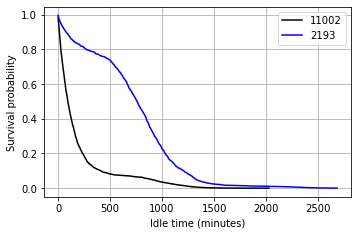

In [90]:
fig = plt.figure(figsize=(5.5, 3.5))

mean = []
upper = []
lower = []
temp_surv = survS[0]
for k in range(len(timeS)):
    vals = temp_surv[k]
    mean.append(np.mean(vals))
plt.plot(timeS,mean, color='k', label=index_specific[0])

mean = []
upper = []
lower = []
temp_surv = survL[0]
for k in range(len(timeL)):
    vals = temp_surv[k]
    mean.append(np.mean(vals))
plt.plot(timeL,mean, color='b', label=index_specific[1])

plt.legend()
plt.xlabel("Idle time (minutes)")
plt.ylabel("Survival probability")
plt.grid()
plt.savefig('../visualization/SA_specificEvents.pdf',bbox_inches='tight')
plt.show()